## Задача по анализу поиска в Яндекс Картинках

Для корректной работы блокнота нужно положить файл data.tsv  в текущую директорию

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from pandasql import sqldf
from tabulate import tabulate

%matplotlib inline

df = pd.read_csv('data.tsv', 
                   sep='\t', 
                   header=None, 
                   names=['query', 'timestamp', 'device'])

#### 1. Диапазон дат, предоставленный для анализа: 
Первый запрос:    31-08-2021 21:00:00 \
Последний запрос: 21-09-2021 20:59:59

In [194]:
min_time_query = """
SELECT MIN(timestamp) as min_time
FROM df
"""

max_time_query = """
SELECT MAX(timestamp) as max_time
FROM df
"""

min_time_unix = sqldf(min_time_query, locals())['min_time'][0]
max_time_unix = sqldf(max_time_query, locals())['max_time'][0]

max_time = pd.to_datetime(max_time_unix, unit='s').strftime('%d-%m-%Y %H:%M:%S')
min_time = pd.to_datetime(min_time_unix, unit='s').strftime('%d-%m-%Y %H:%M:%S')

print(f"Первый запрос:    {min_time}")
print(f"Последний запрос: {max_time}")

Первый запрос:    31-08-2021 21:00:00
Последний запрос: 21-09-2021 20:59:59


#### 2. Количество запросов с текстом "ютуб" в каждой платформе
desktop: 806 \
touch: 732

In [195]:
df['query_lower'] = df['query'].str.lower()

youtube_cnt_query = """
SELECT 
    device, 
    COUNT(*) as query_cnt
FROM df
WHERE query_lower LIKE '%ютуб%'
GROUP BY device
"""
youtube_cnt_table = sqldf(youtube_cnt_query, locals())
print(f"запросы с текстом \"ютуб\"")
print(tabulate(youtube_cnt_table, 
               headers=['', 'device', 'шт'], 
               tablefmt='psql', 
               showindex=list(range(1, len(youtube_cnt_table)+1))))


запросы с текстом "ютуб"
+----+----------+------+
|    | device   |   шт |
|----+----------+------|
|  1 | desktop  |  806 |
|  2 | touch    |  732 |
+----+----------+------+


#### 3. Топ10 самых частотных запросов в каждой платформе (desktop, touch).

In [196]:
df['query_lower'] = df['query'].str.lower().str.replace("ё", "е")

top_10_touch_query = """
SELECT
    query_lower,
    COUNT(*) as cnt,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df WHERE device = 'touch'), 2) as freq_of_touch,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df), 2) as freq_of_all
FROM df
WHERE device = "touch"
GROUP BY query_lower
ORDER BY cnt DESC
LIMIT 10
"""
top_10_touch = sqldf(top_10_touch_query, locals())

total_row_touch = {
    'query_lower': 'ИТОГО:',
    'cnt': top_10_touch['cnt'].sum(),
    'freq_of_touch': top_10_touch['freq_of_touch'].sum(),
    'freq_of_all': top_10_touch['freq_of_all'].sum()
}

separator = pd.DataFrame({col: ['------'] for col in top_10_touch.columns})
 
top_10_touch_with_total = pd.concat([
    top_10_touch,
    separator,
    pd.DataFrame([total_row_touch])
])

In [197]:
top_10_desktop_query = """
SELECT 
    query_lower,
    COUNT(*) as cnt,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df WHERE device = 'desktop'), 2) as freq_of_desktop,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df), 2) as freq_of_all
FROM df
WHERE device = "desktop"
GROUP BY query_lower
ORDER BY cnt DESC
LIMIT 10
"""
top_10_desktop = sqldf(top_10_desktop_query, locals())

total_row_desktop = {
    'query_lower': 'ИТОГО:',
    'cnt': top_10_desktop['cnt'].sum(),
    'freq_of_desktop': round(top_10_desktop['freq_of_desktop'].sum(), 2),
    'freq_of_all': round(top_10_desktop['freq_of_all'].sum(), 2)
}

separator = pd.DataFrame({col: ['------'] for col in top_10_desktop.columns})
 
top_10_desktop_with_total = pd.concat([
    top_10_desktop,
    separator,
    pd.DataFrame([total_row_desktop])
])

touch Топ10 запросов:
+----+-------------------------+----------+--------------+-------------+
|    | Запрос                  | Кол-во   | % от touch   | % от всех   |
|----+-------------------------+----------+--------------+-------------|
| 1  | порно                   | 10076    | 1.27         | 0.84        |
| 2  | секс                    | 8262     | 1.04         | 0.69        |
| 3  | с днем рождения         | 7438     | 0.94         | 0.62        |
| 4  | с днем рождения женщине | 5516     | 0.7          | 0.46        |
| 5  | с днем рождения мужчине | 4339     | 0.55         | 0.36        |
| 6  | хентай                  | 4212     | 0.53         | 0.35        |
| 7  | xxx                     | 3249     | 0.41         | 0.27        |
| 8  | xnxx                    | 2767     | 0.35         | 0.23        |
| 9  | доброе утро             | 2342     | 0.3          | 0.19        |
| 10 | таблица менделеева      | 2278     | 0.29         | 0.19        |
| -- | ------                

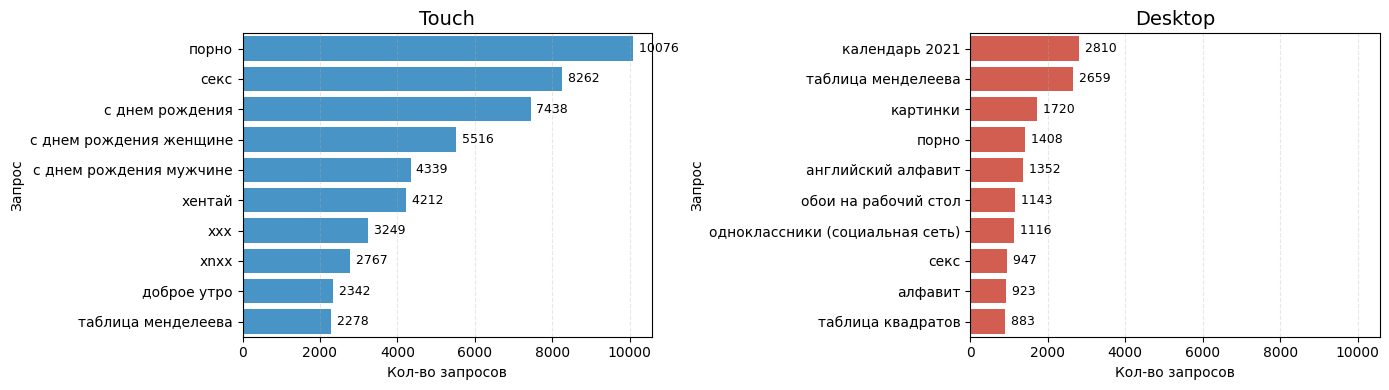

In [234]:

print(f"touch Топ10 запросов:")
print(tabulate(top_10_touch_with_total, 
               headers=['Запрос', 'Кол-во', '% от touch', '% от всех'], 
               tablefmt='psql', 
               showindex=list(range(1, len(top_10_touch_with_total)-1)) + ["--", ""]))

print(f"desktop Топ10 запросов:")
print(tabulate(top_10_desktop_with_total, 
               headers=['Запрос', 'Кол-во', '% от desktop', '% от всех'], 
               tablefmt='psql', 
               showindex=list(range(1, len(top_10_desktop_with_total)-1)) + ["--", ""]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

sns.barplot(data=top_10_touch, x='cnt', y='query_lower', 
            orient='h', color='#3498db', ax=ax1)
sns.barplot(data=top_10_desktop, x='cnt', y='query_lower', 
            orient='h', color='#e74c3c', ax=ax2)

for i, (_, row) in enumerate(top_10_touch.iterrows()):
    ax1.text(row['cnt'] + 50,  
             i,                
             f"{row['cnt']: }", 
             va='center',      
             ha='left',        
             fontsize=9)

for i, (_, row) in enumerate(top_10_desktop.iterrows()):
    ax2.text(row['cnt'] + 50, 
             i, 
             f"{row['cnt']: }", 
             va='center',
             ha='left',
             fontsize=9) 
    
ax1.set_title('Touch', fontsize=14)
ax2.set_title('Desktop', fontsize=14)
ax1.set_xlabel('Кол-во запросов')
ax2.set_xlabel('Кол-во запросов')
ax1.set_ylabel('Запрос')
ax2.set_ylabel('Запрос')

ax1.grid(axis='x', linestyle='--', alpha=0.3)
ax2.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Вывод: 

1. топ10 запросов на touch устройства занимают 4.2% от количества всех запросов, desktop - 1.23%. Пользователи чаще используют сервис Яндекс Картинки с телефона. 

#### 4. Трафик запросов в течении дня 

Ссылка на дашборд с чартами распределения кол-ва запросов по часам в течение дня в datalens (данные обработаны, проиллюстированы и прокомментированы 
в datalens): https://datalens.yandex/p59qkl8yi3jmb 

#### 5. Тематики запросов
Выделим основные категории запросов для touch и desktop устройств на основе топа10 запросов из 3 задания. Получим следующие темы: поздравления, образование, картинки, календарь, утренние картинки, взрослый контент. Классифицируем запросы по категориям и найдем доли каждой категории относительно запросов на устройство.

In [200]:
import re

categories = {
    'поздравления': [
        r'с днем рождения',
        r'поздравл',                         
        r'др'                              
    ],
    'образование': [
        r'таблиц',                    
        r'менделеев',                       
        r'английский алфавит',          
        r'алфавит',                        
        r'квадрат',                          
        r'научн'                            
    ],
    'картинки': [
        r'картинк',                         
        r'обои на рабочий стол'                      
    ],
    'календарь': [
        r'календарь',                    
    ],
    'соц.сети': [
        r'одноклассник',                 
    ],
    '\"доброе утро\"': [
        r'доброе утро'
    ],
    'взрослый контент': [
        r'порно',
        r'секс',
        r'xxx',
        r'xnxx',
    ]
}

compiled_categories = {
    category: [re.compile(pattern, re.IGNORECASE) for pattern in patterns]
    for category, patterns in categories.items()
}

def categorize_query(query):
    query = query.lower().strip()
    for category, patterns in compiled_categories.items():
        if any(pattern.search(query) for pattern in patterns):
            return category
    return 'other'

df['category'] = df['query'].apply(categorize_query)

In [201]:
touch_query_cnt = df[df['device'] == 'touch'].shape[0]
desktop_query_cnt = df[df['device'] == 'desktop'].shape[0]

In [202]:
query_theme_distribution = (
    df.groupby(['category', 'device'])
    .size()
    .unstack()
)

query_theme_distribution = query_theme_distribution.drop('other', axis=0)

query_theme_distribution['touch_part'] = round((query_theme_distribution['touch'] / touch_query_cnt * 100), 2)
query_theme_distribution['desktop_part'] = round((query_theme_distribution['desktop'] / desktop_query_cnt * 100), 2)
query_theme_distribution['difference'] = abs((query_theme_distribution['touch_part'] - query_theme_distribution['desktop_part']))

In [203]:
theme_distribution_final_table = query_theme_distribution.sort_values('difference', ascending=False)[['touch_part', 'desktop_part', 'difference']]

print(tabulate(theme_distribution_final_table, 
               headers=['категория', 'доля (%) на desktop', 'доля (%) на touch', 'разница долей'], 
               tablefmt='psql', 
               showindex=True))

+------------------+-----------------------+---------------------+-----------------+
| категория        |   доля (%) на desktop |   доля (%) на touch |   разница долей |
|------------------+-----------------------+---------------------+-----------------|
| взрослый контент |                  6.34 |                1.49 |            4.85 |
| поздравления     |                  4.37 |                2.34 |            2.03 |
| образование      |                  1.65 |                3.52 |            1.87 |
| календарь        |                  0.82 |                2.38 |            1.56 |
| картинки         |                  3.72 |                3.02 |            0.7  |
| "доброе утро"    |                  0.64 |                0.07 |            0.57 |
| соц.сети         |                  0.02 |                0.32 |            0.3  |
+------------------+-----------------------+---------------------+-----------------+


In [204]:
df_distrib_for_hist = theme_distribution_final_table.reset_index()
melted_df = df_distrib_for_hist.melt(id_vars=['category', 'difference'], 
                    value_vars=['touch_part', 'desktop_part'],
                    var_name='device_type', 
                    value_name='percentage')

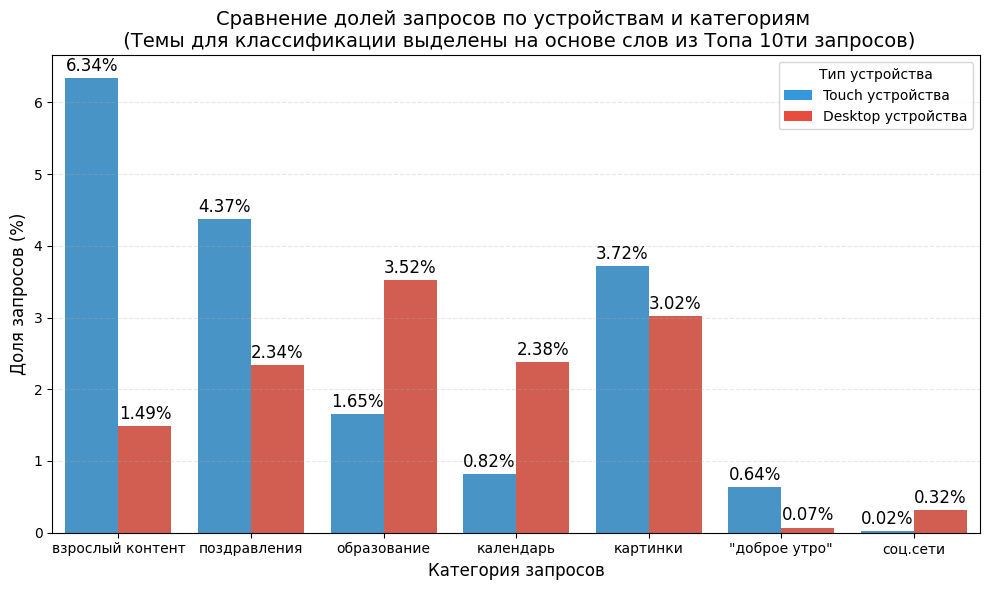

In [214]:
from matplotlib.patches import Patch

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted_df, 
                 x='category', 
                 y='percentage', 
                 hue='device_type',
                 palette={'touch_part': '#3498db', 'desktop_part': '#e74c3c'})

plt.title('Сравнение долей запросов по устройствам и категориям \n (Темы для классификации выделены на основе слов из Топа 10ти запросов)', fontsize=14)
plt.xlabel('Категория запросов', fontsize=12)
plt.ylabel('Доля запросов (%)', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    if height == 0:
        continue
    x_text = p.get_x() + width / 2.
    y_text = height + 0.1
    ax.text(x_text,
            y_text,
            f'{height:.2f}%',
            ha="center", 
            fontsize=12)

legend_elements = [
    Patch(facecolor='#3498db', label='Touch устройства'),
    Patch(facecolor='#e74c3c', label='Desktop устройства')
]
ax.legend(handles=legend_elements, title='Тип устройства')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Вывод: 

1. Наибольшее отличие в долях запросов попадает на темы: взрослый контент, поздравления, образование и календарь

2. Темы, которые более популярны среди пользователей touch устройств: взрослый контент, поздравления, картинки, картинки "с добрым утром"; среди пользователей desktop устройств - образование, календарь, соц.сеть одноклассники.

Хочу обратить внимание на то, что классификация по темам сделана на основе Топ10 запросов для каждого типа устройств. Были взяты фразы или слова из популярных запросов. Больше 80% остальных запросов попали в категорию other и этот факт не отображен на графике. Хвост из остальных 80% запросов может поменять ситуацию.